In [1]:
from irregular_object_packing.packing.optimizer import Optimizer, default_optimizer_config
from irregular_object_packing.mesh.shapes import get_pv_manifold_shape
import numpy as np
from irregular_object_packing.performance_analysis import plots

In [2]:
from dataclasses import dataclass

from irregular_object_packing.cat.chordal_axis_transform import compute_cdt, filter_relevant_cells
from irregular_object_packing.cat.utils import get_cell_arrays

n_objects = 2 ** np.array(range(2, 9))
N = 1

@dataclass
class Result:
    n_objects: int
    iteration: int = 0
    n_vertices: int = 0
    n_cells: int = 0
    n_relevant_cells: int = 0
    catface_cell_ratio: float = 0
    
    
def compute_n_vertices(n_objs, i):
    opt = default_optimizer_config(N=n_objs, mesh_dir='../data/mesh/')
    opt.setup()
    objects = opt.current_meshes()
    meshes = objects + [opt.container]
    n_points_per_object = [mesh.n_points for mesh in meshes]
    tetmesh = compute_cdt(meshes)
    cells = get_cell_arrays(tetmesh.cells)

    rel_cells, _ = filter_relevant_cells(cells, n_points_per_object)
    n_faces = []
    for cell in rel_cells:
        n_faces.append(cell.n_cat_faces_per_obj)

    faces_per_cell = np.average(n_faces)
    
    assert (tetmesh.celltypes == 10).all()

    result = Result(n_objs,
                    iteration=i,
                    n_vertices=tetmesh.n_points,
                    n_cells=tetmesh.n_cells,
                    n_relevant_cells=len(rel_cells),
                    catface_cell_ratio=faces_per_cell,
                    )
    return result    

In [3]:
print("this will take around 5 minutes")
input_str = input("Do you want to run it, or do you want to load the results from a previous run? (y/n)")
load_from_file = input_str == "n"
if not load_from_file:
    print("Running the computation")
    results = []
    for n_obs in n_objects[:]:
        print(f"Computing for {n_obs} objects")
        for i in range(N):
            res = compute_n_vertices(n_obs, i)
            results.append(res)
    print(results)

this will take around 5 minutes


In [4]:
import pandas as pd
if load_from_file:
    df = pd.read_csv("../results/demo-irop-scalability-res.csv")
else:
    df = pd.DataFrame(results)
    df.to_csv("../results/demo-irop-scalability-res-1.csv", index=False)
df

,n_objects,iteration,n_vertices,n_cells,n_relevant_cells,catface_cell_ratio
0,4,0,4052,26709,12669,1.049649
1,8,0,6620,45013,19813,1.065008
2,16,0,11114,78024,33027,1.077512
3,32,0,22028,157618,64675,1.089293
4,64,0,42572,306710,124237,1.094972
5,128,0,83018,605679,245106,1.099720
6,256,0,165836,1220796,488406,1.103244


value at 10E10: 1.1149764209631339
curve fit: -0.11865429944343496 * x ** (1/-2.3554809407097346) + x**(1/50169649.76346502) + 0.11497845312925528


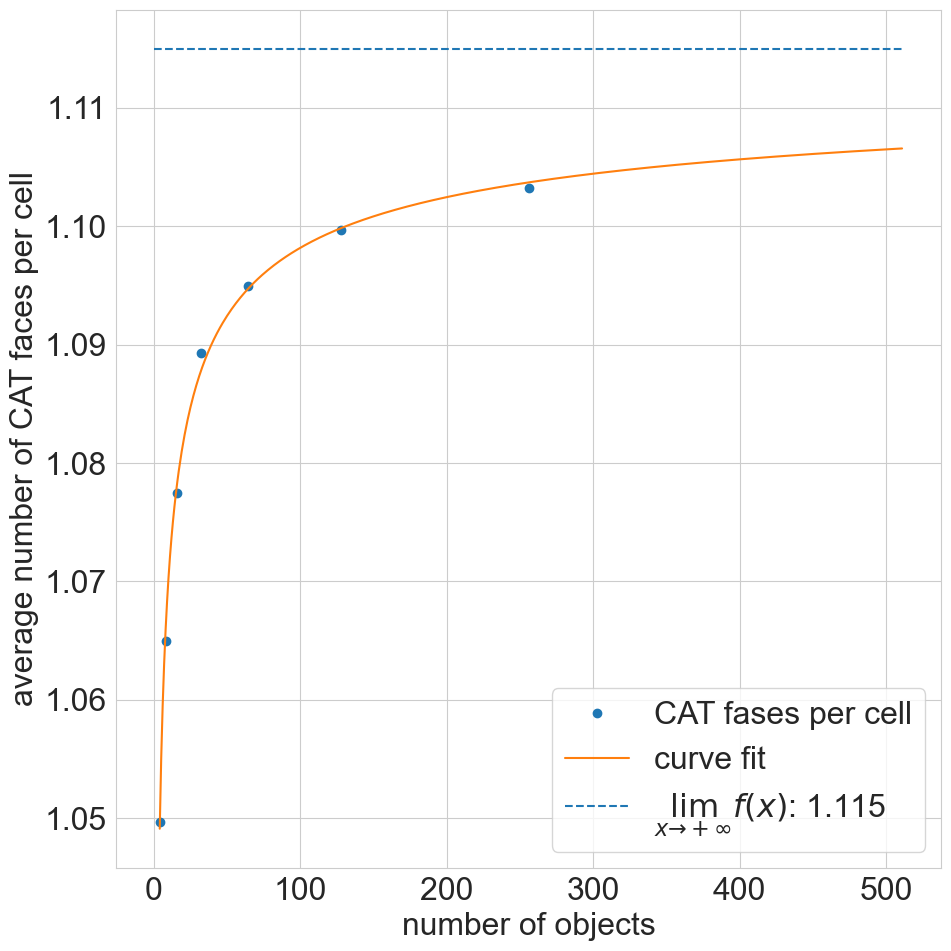

In [28]:
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit

matplotlib.rc('font', size=23)
curve = lambda x, a, b, c, d: a * x ** (1/b) + x**(1/c) + d
# curve = lambda x, a, b, c, d: a * x ** (1/2) + b* x**(1/3) + c + d

fig, ax = plt.subplots(figsize=(10, 10))
n_cells = df.catface_cell_ratio
popt = curve_fit(curve, df.n_objects, n_cells)[0]
x = np.arange(4, 2**9)
y = curve(x, *popt)


plt.plot(df.n_objects, n_cells, 'o', label='CAT fases per cell')
plt.plot(x, y, label='curve fit')
plt.hlines(1+popt[3], 0, 2**9, label=r"$\lim_{x \to +\infty} f(x)$"+ f": {1+popt[3]:.3f}", linestyles='dashed')
plt.legend()
plt.xlabel("number of objects")
plt.ylabel("average number of CAT faces per cell")
print(f"value at 10E10: {curve(10E10, *popt)}")
plt.tight_layout()
print(f"curve fit: {popt[0]} * x ** (1/{popt[1]}) + x**(1/{popt[2]}) + {popt[3]}")
plt.savefig("../results/demo-irop-scalability.pdf")

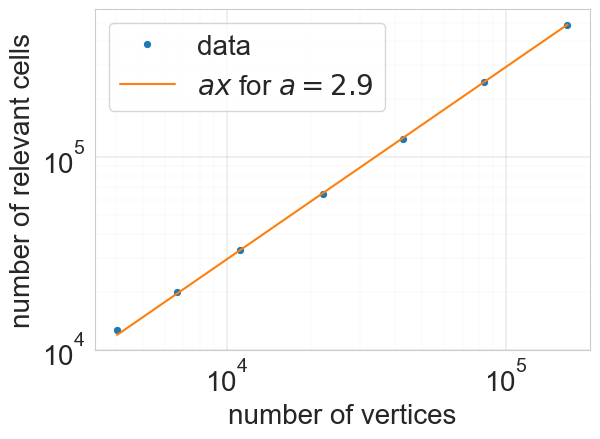

In [51]:
matplotlib.rc('font', size=20)

ax = sns.lineplot(data=df, x="n_vertices", y="n_relevant_cells", marker="o", linestyle="", label="data")
ax.set(xscale="log", yscale="log", )

line = lambda x, a, b: a * x + b
popt = curve_fit(line, df.n_vertices, df.n_relevant_cells)[0]
x = np.arange(min(df.n_vertices), max(df.n_vertices))
y = line(x, popt[0], 0)

ax.plot(x, y, label=r'$ax$ for $a={:.1f}$'.format(*popt))
plt.xlabel("number of vertices")
plt.ylabel("number of relevant cells")
ax.grid(which='major', color='grey', linewidth=0.175)
ax.grid(which='minor', color='lightgrey', linewidth=0.075)
ax.tick_params(which='minor')
# set the x and y ticks to scientific notation
# plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.legend()
plt.tight_layout()
plt.savefig("../results/demo-irop-scalability-CAT.pdf")